In [1]:
import collections
import math
import torch
import os
import time
from torch.utils import data
import hashlib
import zipfile
from IPython import display
from torch import nn
from matplotlib import pyplot as plt
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, x, *args):
        raise NotImplementedError

In [3]:
class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        
    def forward(self, x, *args):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        output, state = self.rnn(x)
        return output, state

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
x = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(x)
output.shape

torch.Size([7, 4, 16])

In [5]:
state.shape

torch.Size([2, 4, 16])

In [6]:
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
        
    def forward(self, x, state):
        raise NotImplementedError

In [7]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                         dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, x, state):
        x = self.embedding(x).permute(1, 0, 2)
        context = state[-1].repeat(x.shape[0], 1, 1)
        x_and_context = torch.cat((x, context), 2)
        output, state = self.rnn(x_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                        num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(x))
output, state = decoder(x, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [9]:
def sequence_mask(x, valid_len, value=0):
    maxlen = x.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                       device=x.device)[None, :] < valid_len[:, None]
    x[~mask] = value
    return x

x = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(x, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [10]:
x = torch.ones(2, 3, 4)
sequence_mask(x, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [11]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                             self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [12]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
    torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [13]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                       xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)
        for batch in data_iter:
            x, x_valid_len, y, y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * y.shape[0],
                              device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, y[:, :-1]], 1)
            y_hat, _ = net(x, dec_input, x_valid_len)
            l = loss(y_hat, y, y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            num_tokens = y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f}' 
         f'tokens/sec on {str(device)}')

In [14]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def load_data_nmt(batch_size, num_steps, num_examples=600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

def read_data_nmt():
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
    
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)    

def build_array_nmt(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = reduce_sum(astype(array != vocab['<pad>'], torch.int32),
                           1)
    return array, valid_len

def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)
    
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[
                                                0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
    
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
            
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

loss 0.019, 18063.2tokens/sec on cuda:0


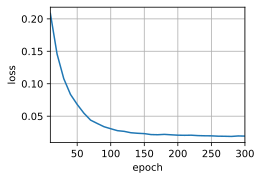

In [15]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, try_gpu()
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)